In [1]:
from model import EAST
from detect import *

import os
import torch
import json
import random

import cv2
import matplotlib.pyplot as plt

import copy

1. config setting

In [2]:
# 1) 훈련된 .pth 파일 경로
ckpt_path = "/opt/ml/code/trained_models/latest.pth"
# 2) 시각화하고 싶은 json 파일 경로
json_path = "/opt/ml/input/data/BOOSTCAMP/images/ufo/train.json"
# 3) 이미지 폴더 경로
img_folder_root = "/opt/ml/input/data/BOOSTCAMP/images"

# 4) inference시에 input_size값으로 LongestMaxSize를 적용하게 됨. default 값은 1024
input_size = 1024
# 5) 시각화 하고 싶은 이미지 개수
num_inference = 3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
with open(json_path) as f:
    train_json = json.load(f)
    
img_names = list(train_json['images'].keys()) # json에 들어있는 모든 이미지 이름 저장

In [4]:
target_names = ['0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG'] # 시각화 하고 싶은 이미지 이름 저장
for _ in range(num_inference):
    img_list_idx = random.randint(0, len(img_names)-1)
    target_names.append(img_names[img_list_idx])

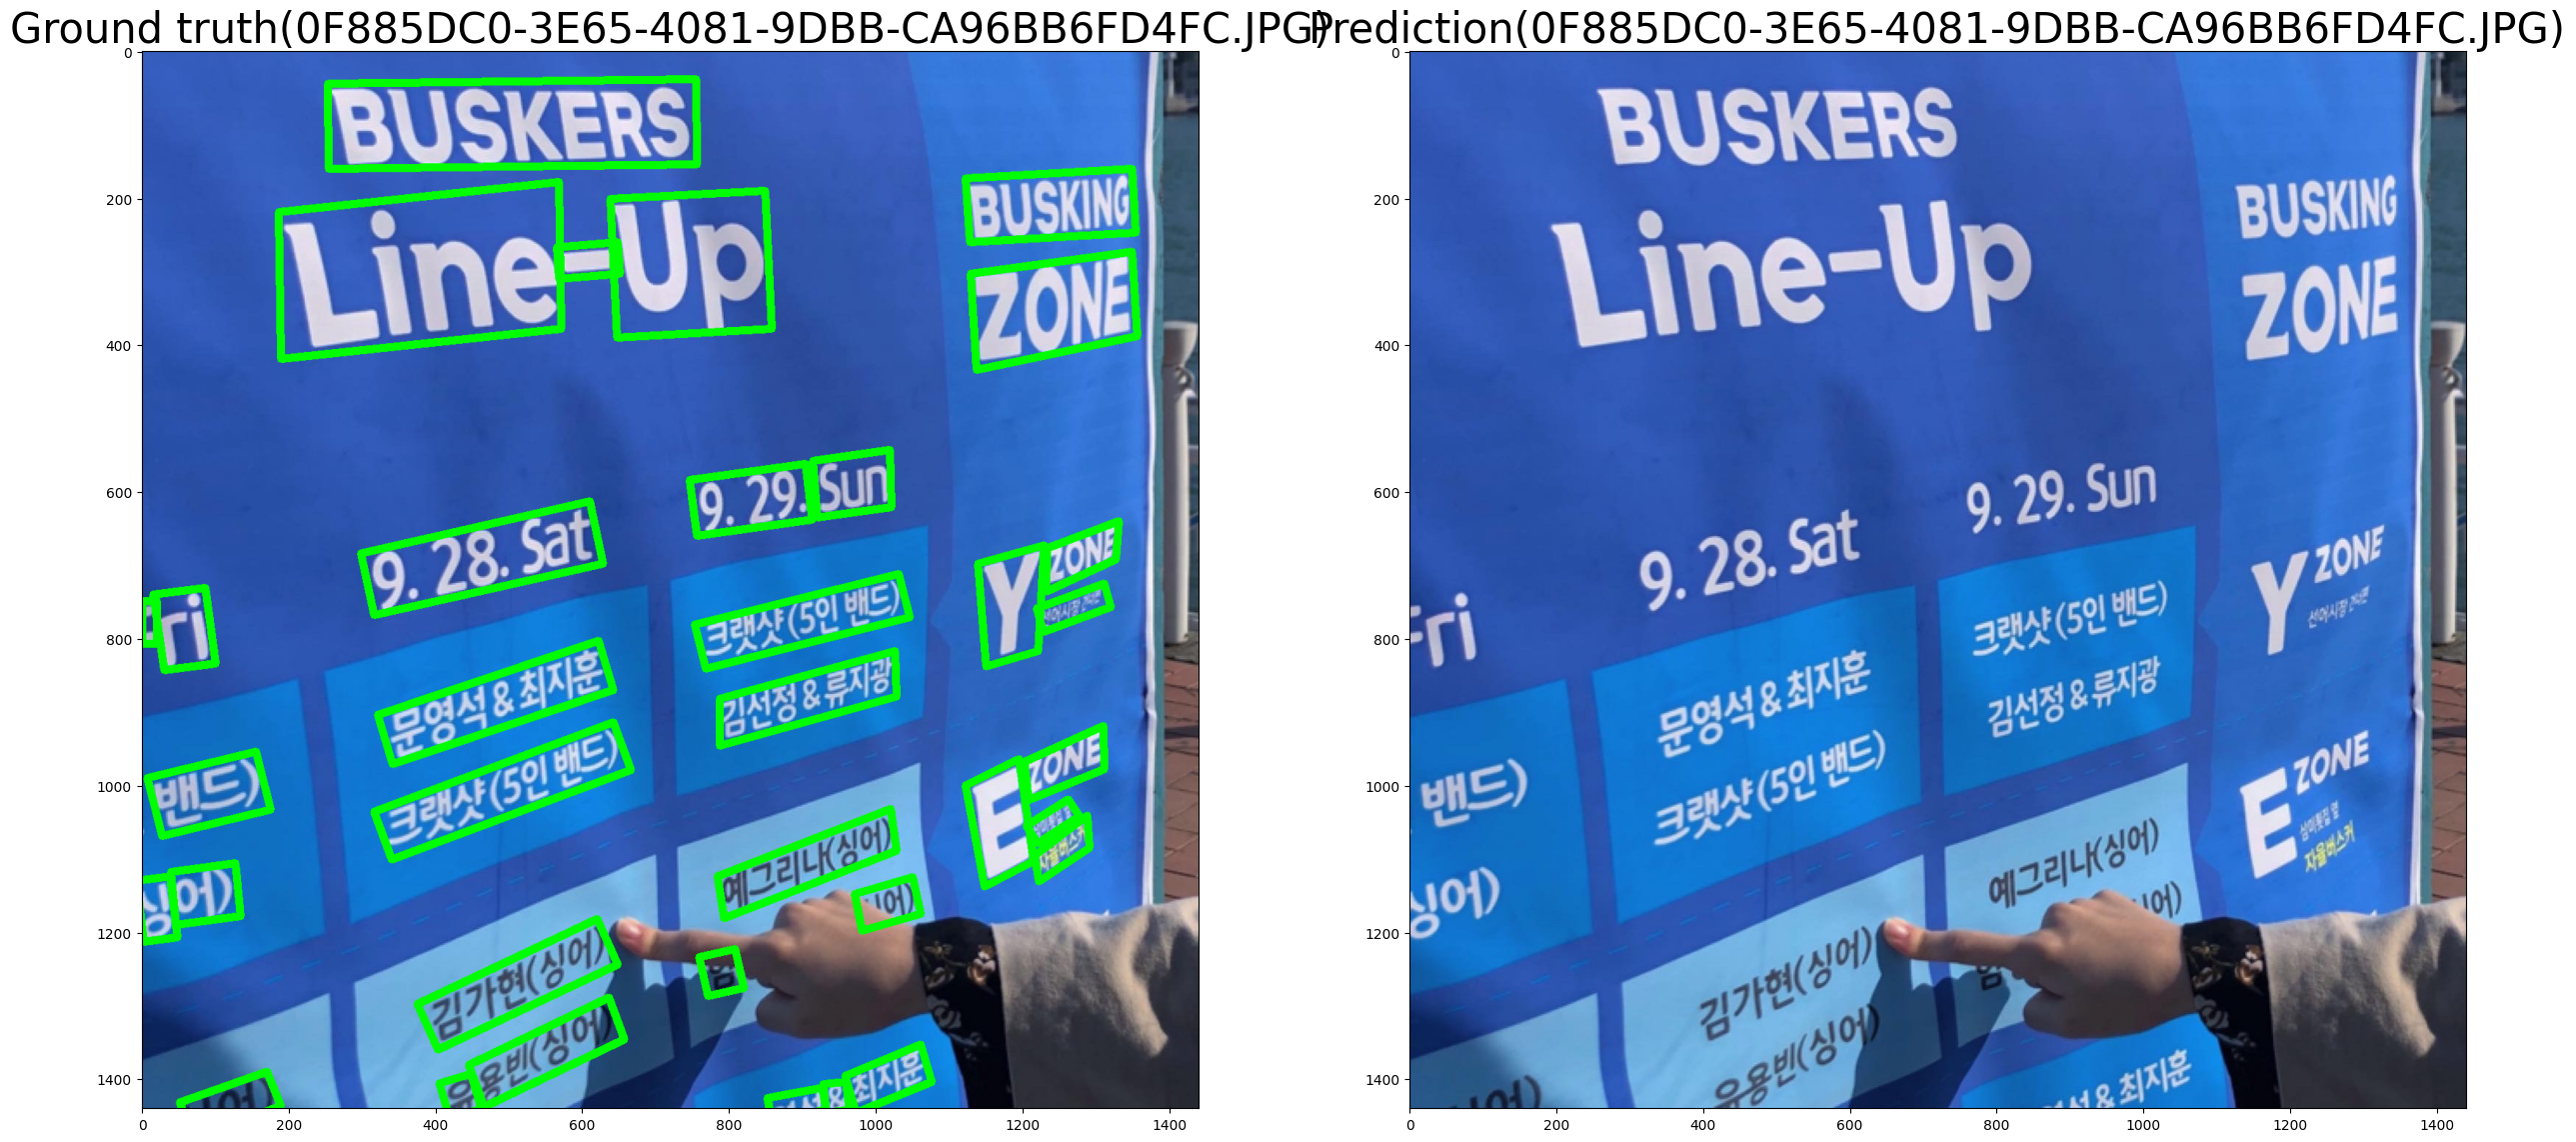

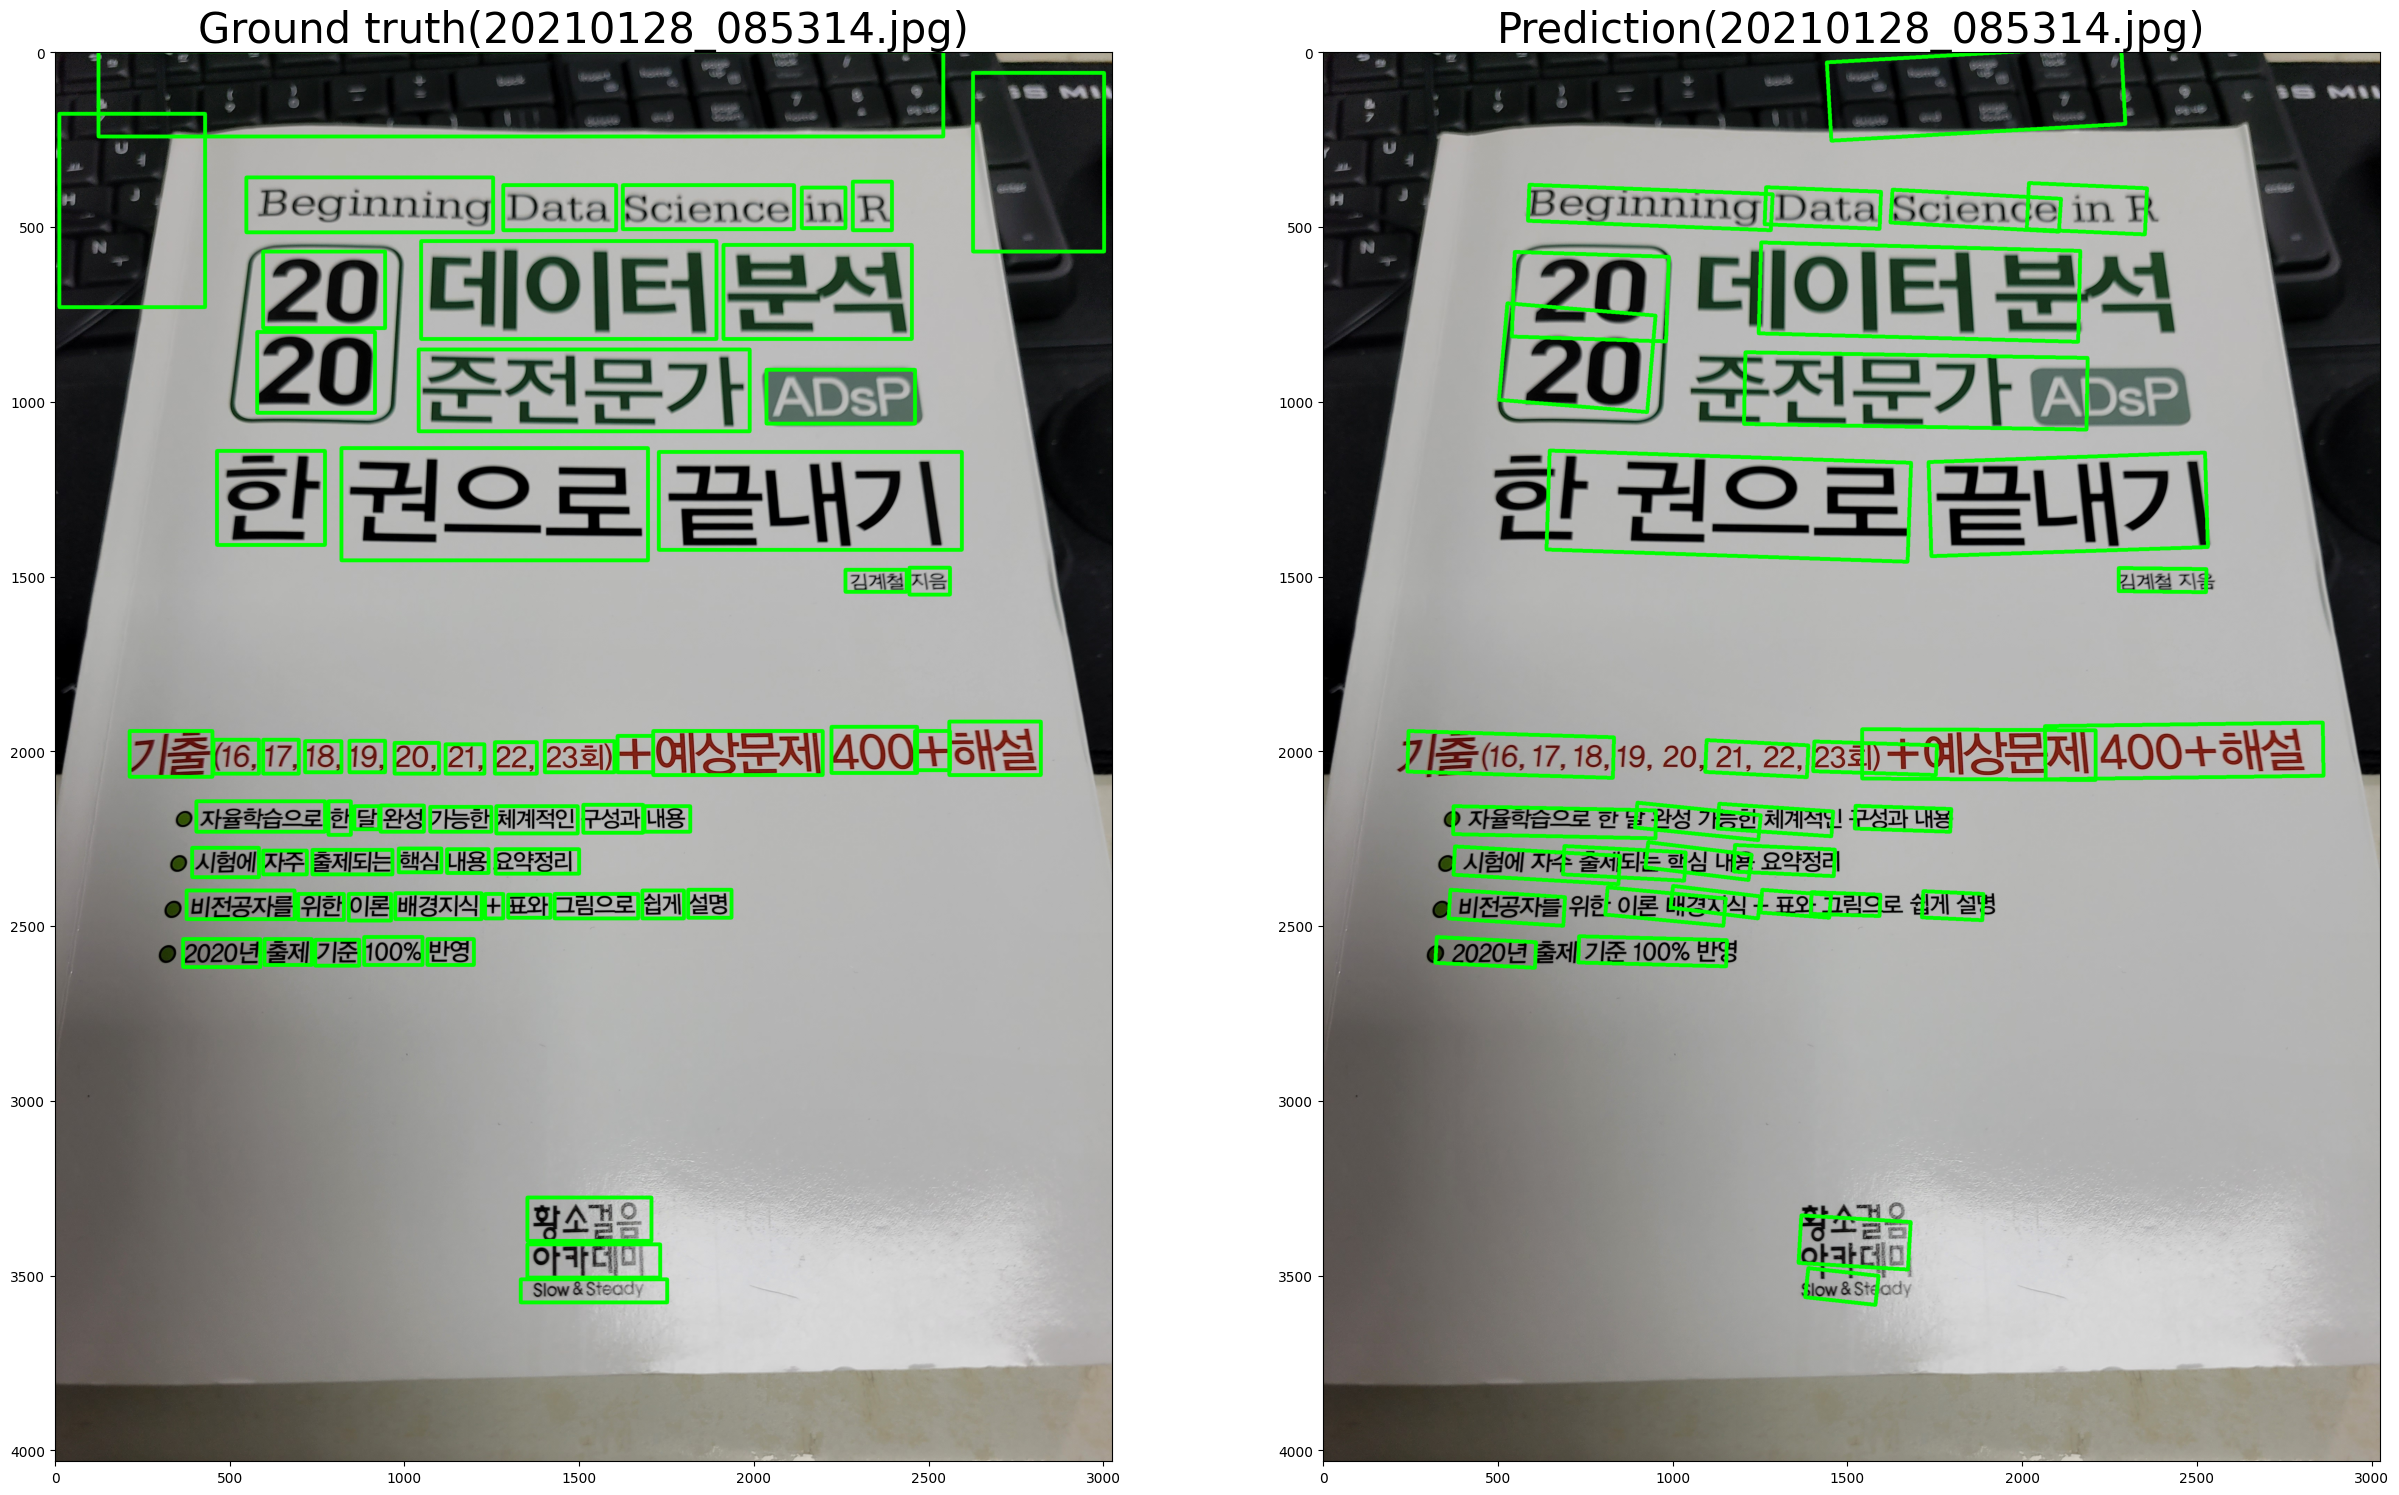

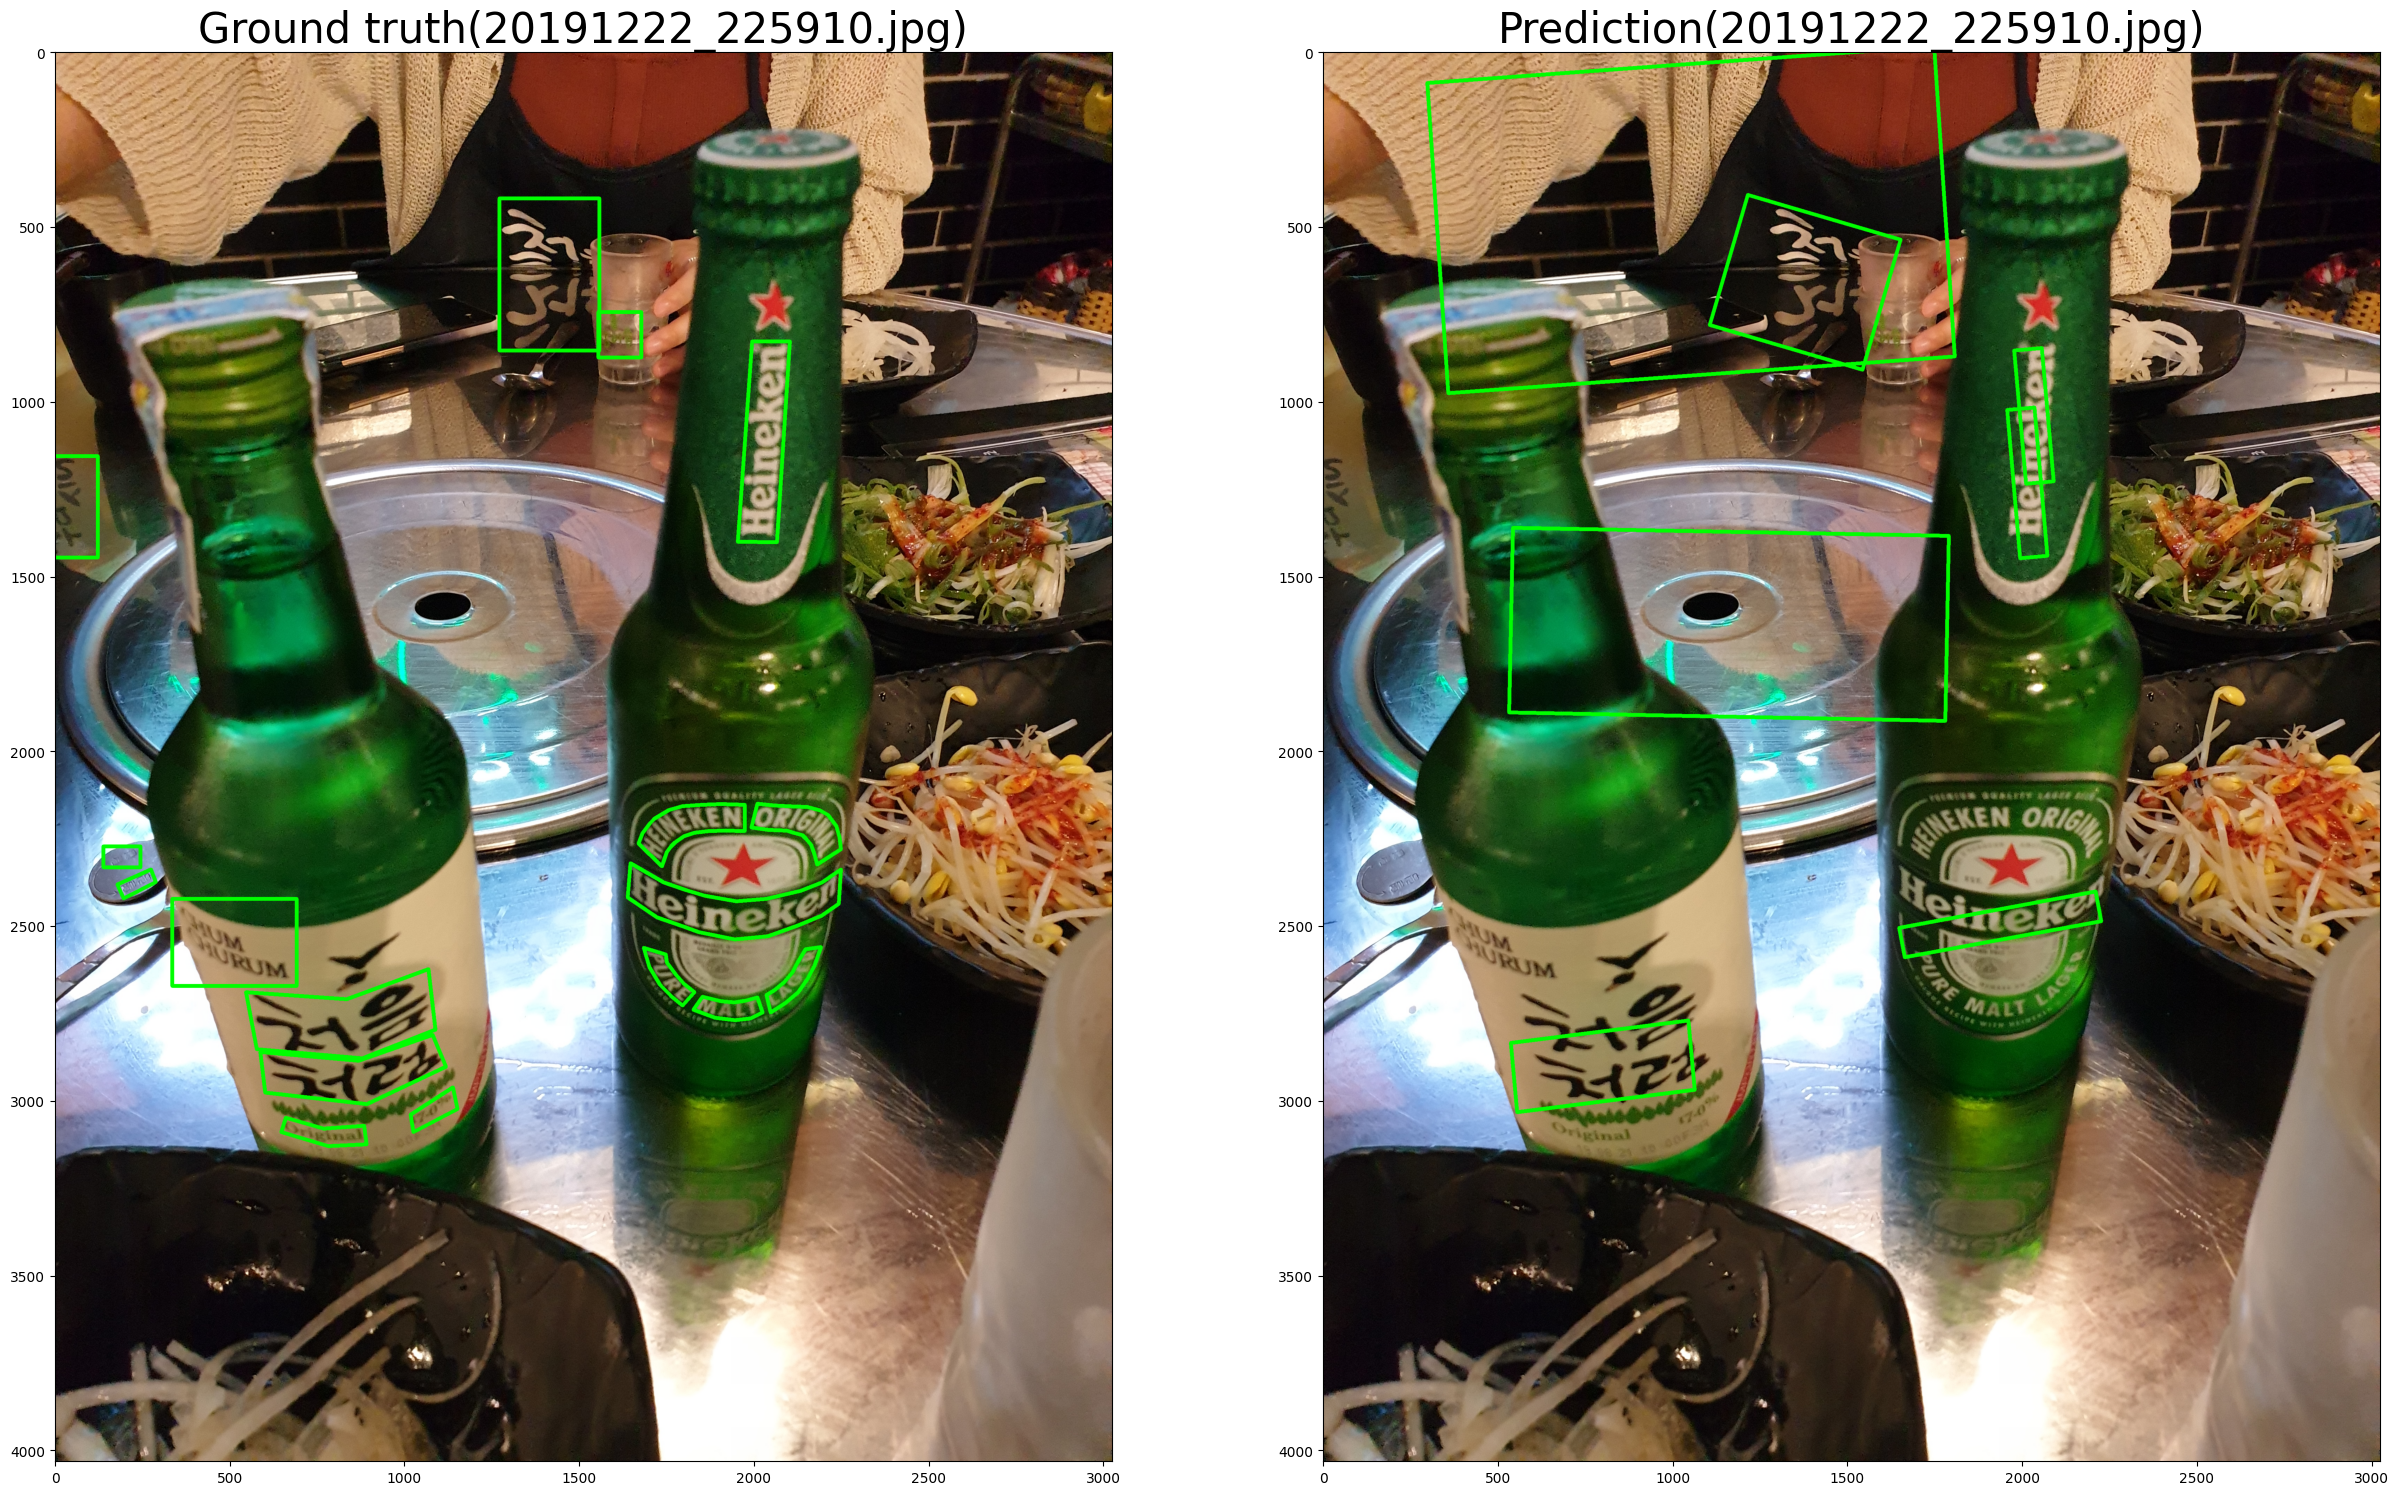

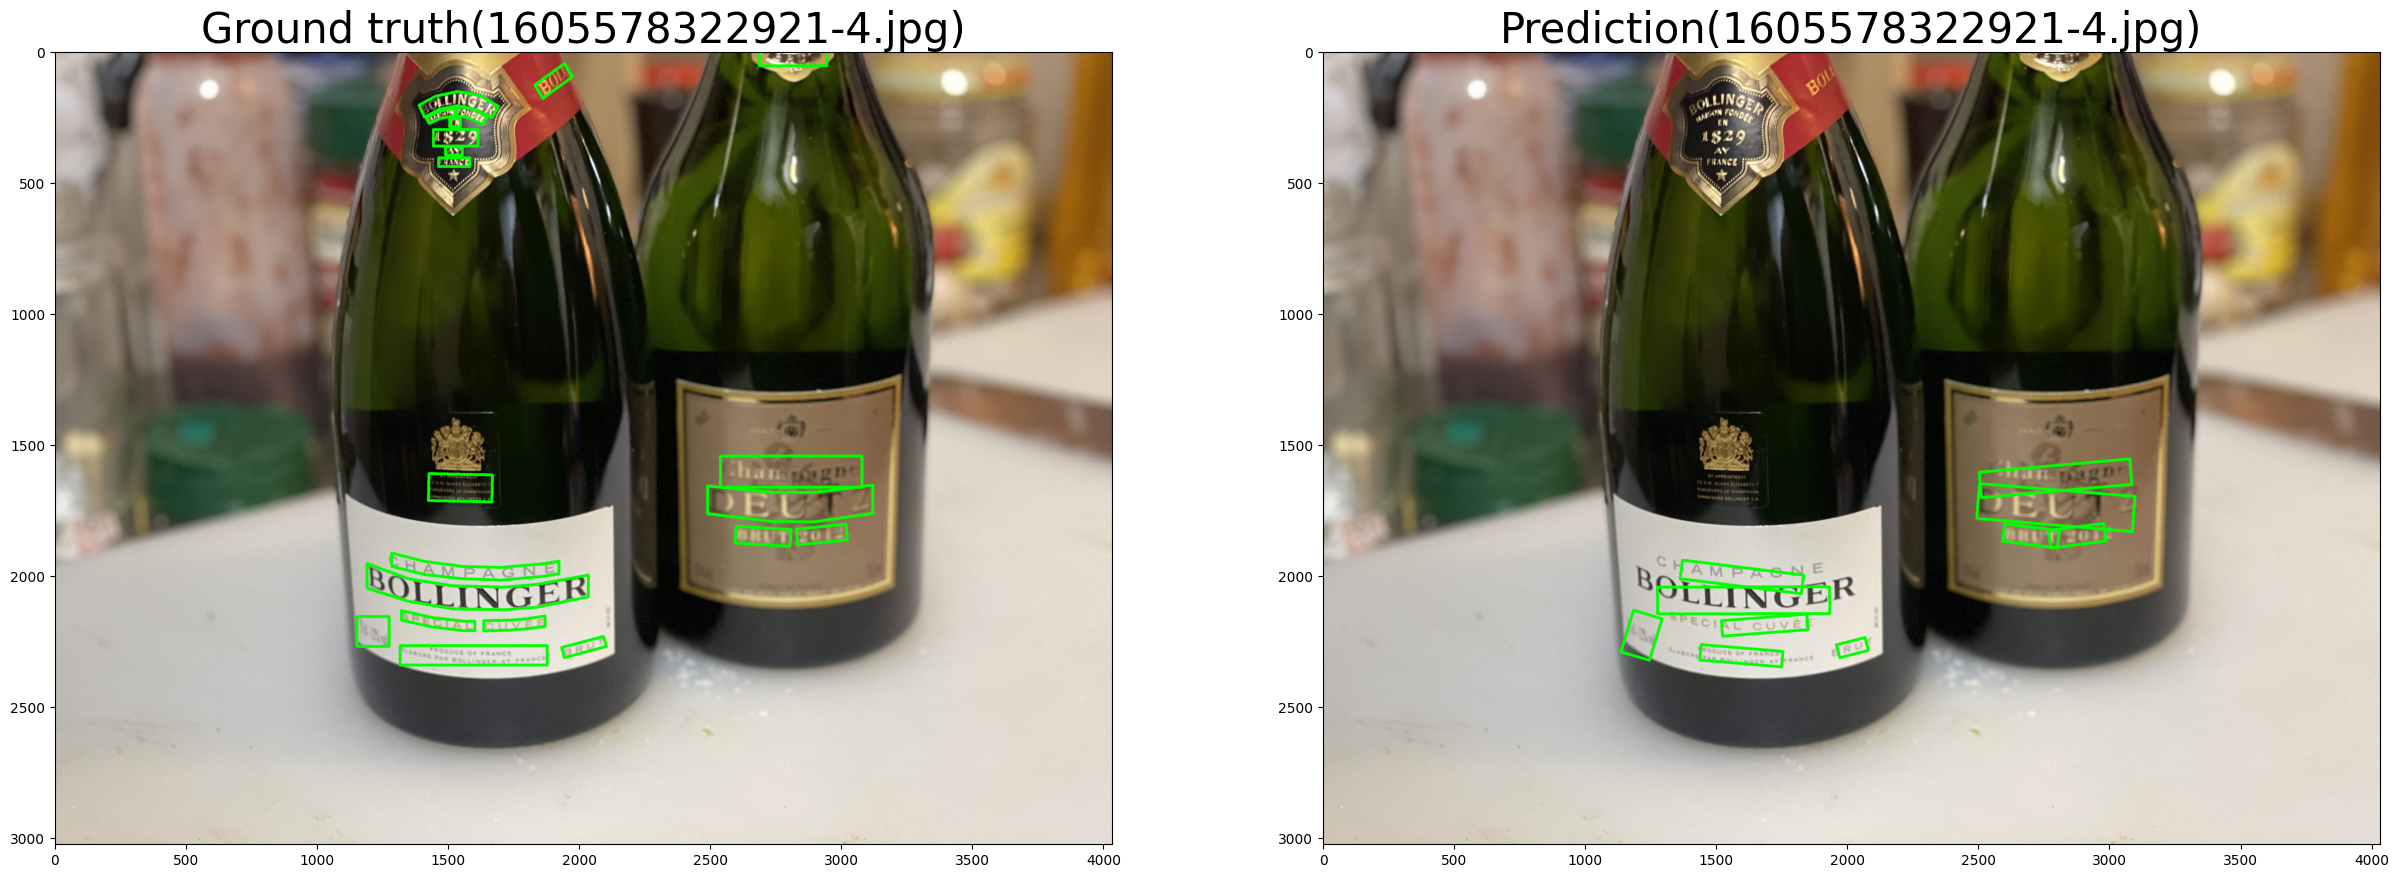

In [5]:
model = EAST(pretrained=False).to(device)
model.load_state_dict(torch.load(ckpt_path))

images = []
for name in target_names:
    img_path = os.path.join(img_folder_root, name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

bboxes = detect(model, images, input_size)
tmp_bboxes = []
for output in bboxes:
    tmp_bboxes.append(output.tolist())
bboxes = tmp_bboxes

for batch_idx, image in enumerate(images):
    image_gt = copy.deepcopy(image)
    image_pred = copy.deepcopy(image)
    target_name = target_names[batch_idx]
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30,30))

    # ax1: ground truth 시각화
    words = train_json['images'][target_names[batch_idx]]['words']
    for key, value in words.items():
        points = value['points']
        for i in range(len(points)-1):
            start_point = points[i]
            end_point = points[i+1]
            cv2.line(image_gt, tuple(map(round, start_point)), tuple(map(round, end_point)), (0,255,0), 10)

        start_point = points[-1]
        end_point = points[0]
        cv2.line(image_gt, tuple(map(round, tuple(start_point))), tuple(map(round, tuple(end_point))), (0,255,0), 10)
    ax1.set_title(f'Ground truth({target_name})', fontsize=30)
    ax1.imshow(image_gt)

    # ax2: model prediction 결과 시각화
    for points in bboxes[batch_idx]:
        for i in range(len(points)-1):
            start_point = points[i]
            end_point = points[i+1]
            cv2.line(image_pred, tuple(map(round, start_point)), tuple(map(round, end_point)), (0,255,0), 10)

        start_point = points[-1]
        end_point = points[0]
        cv2.line(image_pred, tuple(map(round, start_point)), tuple(map(round, end_point)), (0,255,0), 10)

    ax2.set_title(f'Prediction({target_name})', fontsize=30)
    ax2.imshow(image_pred)
